## Volatility Risk Premium - Stochastic Volatility

In [216]:
USER_PATH <- "D:/Softwares/"
USER_PATH2 <- "D:/Softwares/GitHub/Discrete-SV-Models-Estimation/Code/" # Change only here
ILLUS_PATH <- paste0(USER_PATH2, "Illustration/")
DATA_INPUT_PATH <- paste0(USER_PATH,"GitHub/Systemic_Risk_Measures/Code/Python/Data_Extraction/")
FUNCTION_PATH <- paste0(USER_PATH, "GitHub/Systemic_Risk_Measures/Code/R/Functions/")

In [217]:
source(paste0(FUNCTION_PATH, "CoVaR_project2.R"))
source(paste0(FUNCTION_PATH, "CoVaR_Functions.R"))

In [218]:
library(ggplot2)
library(dplyr)
library(tidyquant)
library(stats)
library(tibble)
library(base)
library(tidyverse)
library(reshape2)
library(pbivnorm)
library(MASS)
library(stargazer)

#### 0) Load Real Data

In [219]:
returns <- read.csv(paste0(DATA_INPUT_PATH, 'RD_RETURNS.csv'))
# returns <- read.csv(paste0(DATA_INPUT_PATH, 'RD_RETURNS_01.csv'))
returns <- returns[,2:length(returns[1,])]
vix <- read.csv(paste0(DATA_INPUT_PATH, 'CBOE_VIX_DATA.csv'))

In [220]:
DATE <- returns[,1]
data_returns <- returns[,2:length(returns[1,])]
system <- data_returns[,1]
stocks <- data_returns[,2:length(data_returns[1,])]
tickers <- colnames(stocks)
M <- length(tickers)
date_vix <- vix[,1]
vix_p <- vix[,2] / sqrt(252)

In [225]:
DATE[3250]

[1] "2021-12-31"

#### I) QML Method

In [176]:
obj_sv <- function(theta, epsilon){
    alpha_t <- c()
    P_t <- c()
    F_t <- c()
    K_t <- c()
    omega <- theta[1]
    beta <- theta[2]
    sigma <- theta[3]
    mu_Z <- -1.270
    sigma_Z <- sqrt(pi**2/2)
    
    a0 <- 0
    beta0 <- 0.8
    P0 <- sigma**2
    F0 <- P0 + sigma_Z**2
    
    T <- length(epsilon)
    y_t <- log(epsilon**2)
    
    alpha_t[1] <- beta0 * a0 + omega
    P_t[1] <- beta**2 * P0 + sigma**2
    K_t[1] <- beta * P0 * 1/F0
    
    for (t in 2:T){
        F_t[t-1] <- P_t[t-1] + sigma_Z**2
        K_t[t] <- beta * P_t[t-1] * 1/F_t[t-1]
        alpha_t[t] <- beta * alpha_t[t-1] + K_t[t] *
            (y_t[t-1] - alpha_t[t-1] - mu_Z) + omega
        P_t[t] <- beta**2 * P_t[t-1] - K_t[t]**2 * F_t[t-1] + sigma**2
    }
    F_t[T] <- P_t[T-1] + sigma_Z**2
    qml <- -T/2 * log(2*pi) - 1/2*sum(log(F_t) +
        (log(epsilon**2) - alpha_t - mu_Z)**2 / F_t)
    -qml
}

In [177]:
estim_sv <- function(theta0, epsilon){
    valinit <- theta0
    lower <- c(-Inf, 0, 0)
    upper <- c(Inf, 0.999, Inf)
    res <- nlminb(valinit, obj_sv, lower=lower,
                  upper=upper, epsilon=epsilon)
    theta_hat <- res$par[1:3]
    theta_hat
}

In [178]:
# stocks <- stocks[,5]
stocks <- system

In [179]:
selection <- 2500:3000
epsilon <- (stocks+0.000001) * 100
epsilon <- epsilon[selection]
DATE <- as.Date(returns[selection,1])
DATE_VIX <- as.Date(date_vix)
T <- length(epsilon)

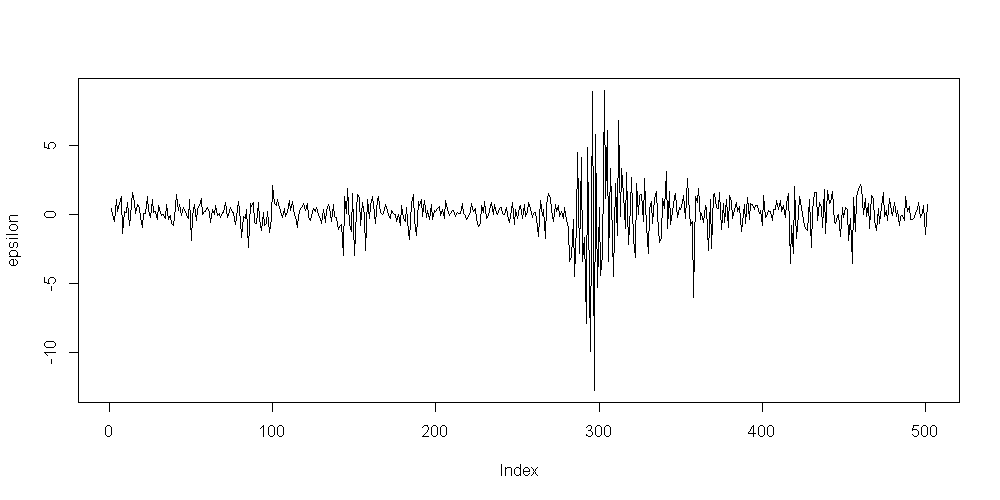

In [180]:
plot(epsilon, type='l')

In [181]:
# Estimation Inputs
omega0 <- -0.6
beta0 <- 0.9
sigma0 <- 0.5
theta0 <- c(omega0, beta0, sigma0)

### A/ Stochastic Volatility Model

In [182]:
estimation <- estim_sv(theta0, epsilon)
theta_hat <- estimation
theta_hat

[1] -0.005392857  0.963549672  0.384444630

In [183]:
alpha_t <- c()
P_t <- c()
F_t <- c()
K_t <- c()
omega <- theta_hat[1]
beta <- theta_hat[2]
sigma <- theta_hat[3]
mu_Z <- -1.270
sigma_Z <- sqrt(pi**2/2)
    
a0 <- 0
beta0 <- 0.8
P0 <- sigma**2
F0 <- P0 + sigma_Z**2
    
T <- length(epsilon)
y_t <- log(epsilon**2)
    
alpha_t[1] <- beta0 * a0 + omega
P_t[1] <- beta**2 * P0 + sigma**2
K_t[1] <- beta * P0 * 1/F0
    
for (t in 2:T){
    F_t[t-1] <- P_t[t-1] + sigma_Z**2
    K_t[t] <- beta * P_t[t-1] * 1/F_t[t-1]
    alpha_t[t] <- beta * alpha_t[t-1] + K_t[t] *
            (y_t[t-1] - alpha_t[t-1] - mu_Z) + omega
    P_t[t] <- beta**2 * P_t[t-1] - K_t[t]**2 * F_t[t-1] + sigma**2
}

## GARCH Model

In [184]:
omega_0 <- -0.6
alpha_0 <- 0.1
beta_0 <- 0.85

In [185]:
# Initialisation
sigma2_hat <- c()
eta_hat <- c()

estimation <- estimgarch11(omega_0, alpha_0, beta_0, epsilon)
theta_hat_g <- estimation$coef

omega_hat_g <- theta_hat_g[1]
alpha_hat_g <- theta_hat_g[2]
beta_hat_g <- theta_hat_g[3]

sigma2_hat[1]<-omega_hat_g
eta_hat[1] <- epsilon[1] / sqrt(sigma2_hat[1])
for (i in 2:T){
    sigma2_hat[i]<-omega_hat_g + alpha_hat_g * epsilon[i-1]**2 + beta_hat_g * sigma2_hat[i-1]
    eta_hat[i] <- epsilon[i] / sqrt(sigma2_hat[i])
}

In [186]:
# Load Data
t<-1:T
col_names<-c('t', 'returns', 'stochastic volatility', 'garch volatility')
confidence_tab <- as.data.frame(epsilon)
confidence_tab <- cbind(confidence_tab, sqrt(exp(alpha_t)))
confidence_tab <- cbind(confidence_tab, sqrt(sigma2_hat))
confidence_tab <- cbind(t, confidence_tab)
colnames(confidence_tab) <- col_names
confidence_tab <- melt(confidence_tab, id="t")
confidence_tab <- cbind(rep(DATE[1:T]), confidence_tab)
colnames(confidence_tab) <- c('Date', 't', 'variable', 'value')

In [187]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100)
confidence_chart <-ggplot(data=confidence_tab, aes(x=Date, y=value, colour=variable))+
    geom_line(lwd=0.5)+
    theme_classic()+
    scale_color_manual(name = "Variables", values= c('black', 'blue', 'red'),
                       labels = c('Returns', 'Stochastic Volatility', 'Garch Volatility'))+
    labs(title = "S&P 500 Returns vs. Stochastic & GARCH Volatility"
         , x = "Time", y="Value")+
    theme(
        axis.title = element_text(size =12),
        axis.text = element_text(size = 12, color = 'black')
    )

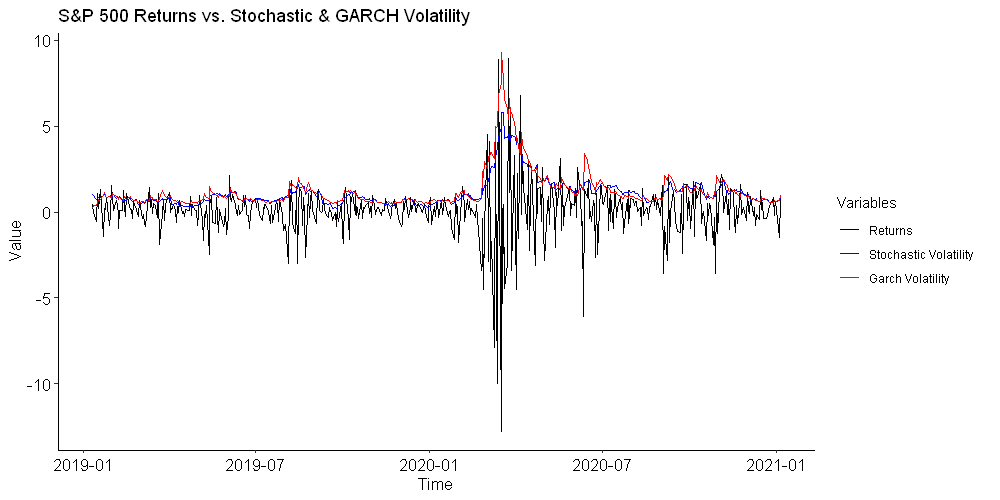

In [188]:
confidence_chart

In [189]:
# pdf(file=paste0(ILLUS_PATH, "QML_volat_RD.pdf"),width=10, height=5)
# confidence_chart
# dev.off()

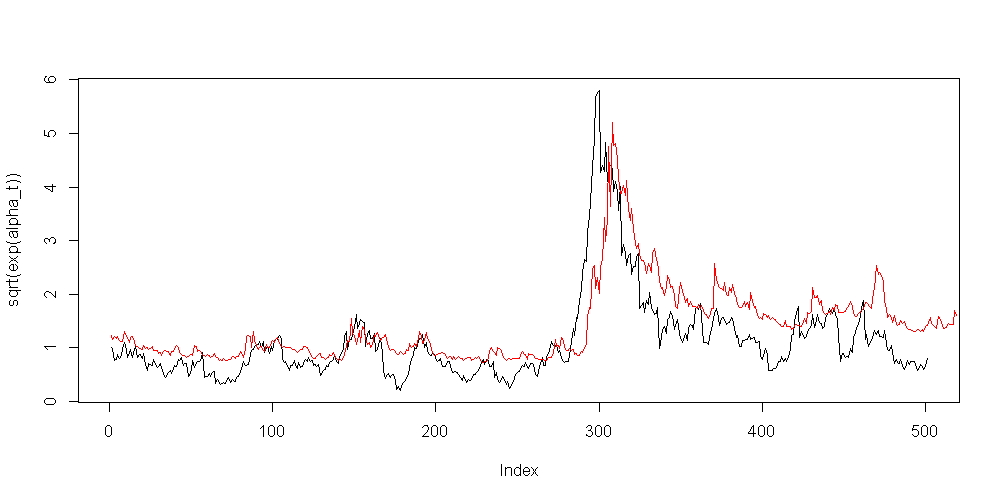

In [190]:
plot(sqrt(exp(alpha_t)), type='l', col='black')
lines(vix_p, type='l', col='red')
lines(sqrt(var(epsilon)), type='l', col='blue')

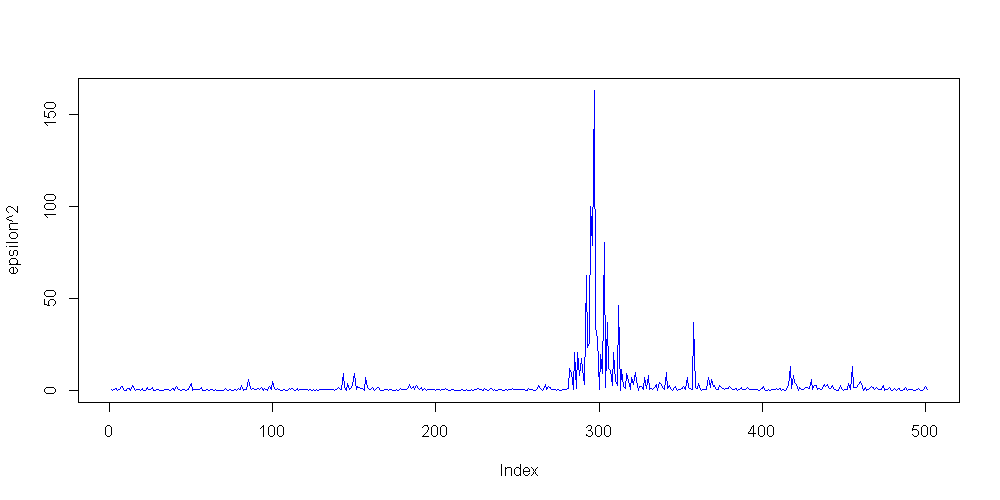

In [191]:
plot(epsilon**2, type='l', col='blue')

In [192]:
epsilon <- (stocks+0.000001) * 100
stop <- length(epsilon)
realized_vol <- c()
trad <- 21
for (t in (1+trad):stop){
    realized_vol[t] <- sqrt(var(epsilon[(t-trad):t]))
}

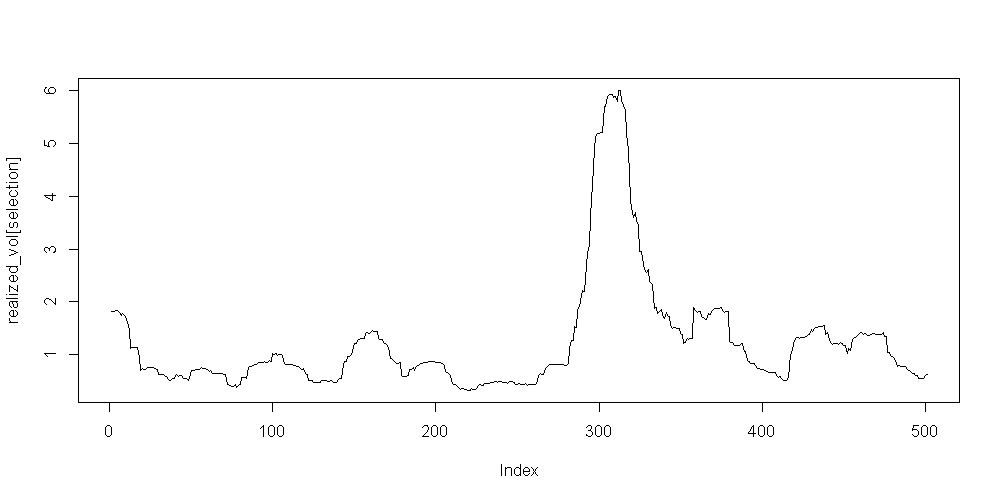

In [193]:
plot(realized_vol[selection], type='l')

In [204]:
vix_100 <- vix_p[1:501] 
garch_100 <- sqrt(sigma2_hat) / mean(sqrt(sigma2_hat))
realized_100 <- realized_vol[selection]
stoch_100 <- sqrt(exp(alpha_t))

In [205]:
# Load Data
t<-1:T
col_names<-c('t', 'vix', 'SV volatility', 'realized volatility (1 month lagging)')
confidence_tab_vix <- as.data.frame(vix_100)
confidence_tab_vix <- cbind(confidence_tab_vix, stoch_100)
confidence_tab_vix <- cbind(confidence_tab_vix, realized_100)
confidence_tab_vix <- cbind(t, confidence_tab_vix)
colnames(confidence_tab_vix) <- col_names
confidence_tab_vix <- melt(confidence_tab_vix, id="t")
confidence_tab_vix <- cbind(rep(DATE[1:T]), confidence_tab_vix)
colnames(confidence_tab_vix) <- c('Date', 't', 'variable', 'value')

In [206]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100)
confidence_chart_vix <-ggplot(data=confidence_tab_vix, aes(x=Date, y=value, colour=variable))+
    geom_line(lwd=0.5)+
    theme_classic()+
    scale_color_manual(name = "Variables", values= c('blue', 'red', 'purple'),
                       labels = c('Vix', 'SV Volatility', 'Realized Volatility (1 month lagging)'))+
    labs(title = "S&P 500 Volatility vs. VIX"
         , x = "Time", y="Value")+
    theme(
        axis.title = element_text(size =12),
        axis.text = element_text(size = 12, color = 'black')
    )

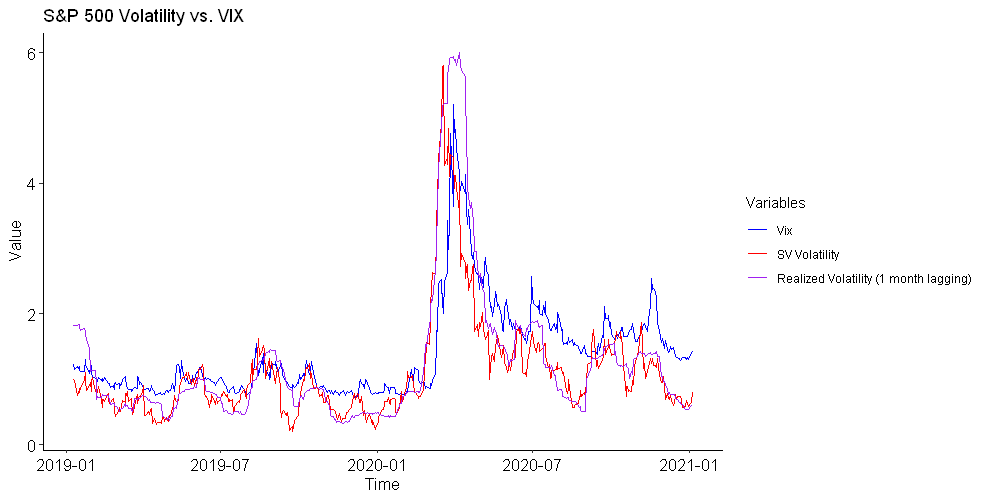

In [208]:
confidence_chart_vix

In [209]:
pdf(file=paste0(ILLUS_PATH, "VRP_Comp.pdf"),width=10, height=5)
confidence_chart_vix
dev.off()

png 
  2

#### Spread

In [210]:
# Load Data
t<-1:T
col_names<-c('t', 'volatility risk premium (conditional)', 'volatility risk premium (realized)',
             'zero line')
confidence_tab_spread <- as.data.frame(vix_100 - stoch_100)
confidence_tab_spread <- cbind(confidence_tab_spread, vix_100 - realized_100)
confidence_tab_spread <- cbind(confidence_tab_spread, rep(0, 501))
confidence_tab_spread <- cbind(t, confidence_tab_spread)
colnames(confidence_tab_spread) <- col_names
confidence_tab_spread <- melt(confidence_tab_spread, id="t")
confidence_tab_spread <- cbind(rep(DATE[1:T]), confidence_tab_spread)
colnames(confidence_tab_spread) <- c('Date', 't', 'variable', 'value')

In [211]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100)
confidence_chart_spread <-ggplot(data=confidence_tab_spread, aes(x=Date, y=value, colour=variable))+
    geom_line(lwd=0.5)+
    theme_classic()+
    scale_color_manual(name = "Variables", values= c('black', 'red', 'blue'),
                       labels = c('Volatility Risk Premium (stochastic)',
                                  'Volatility Risk Premium (realized)','Zero Line'))+
    labs(title = "Volatility Risk Premium"
         , x = "Time", y="Value")+
    theme(
        axis.title = element_text(size =12),
        axis.text = element_text(size = 12, color = 'black')
    )

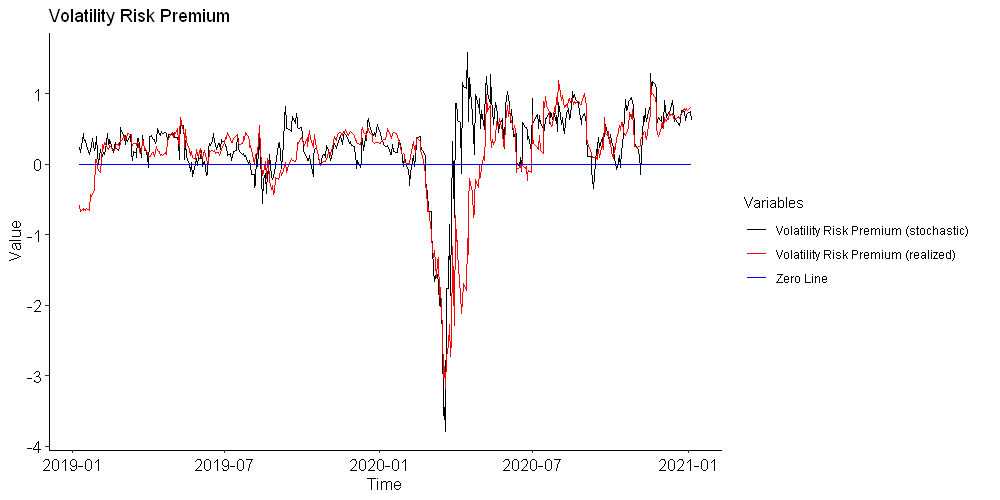

In [212]:
confidence_chart_spread

In [213]:
pdf(file=paste0(ILLUS_PATH, "VRP_Spread.pdf"),width=10, height=5)
confidence_chart_spread
dev.off()

png 
  2

In [163]:
vix_100 -realized_100

[1] -5.914483e-01 -6.732299e-01 -6.203435e-01 -6.620905e-01 -6.354153e-01
  [6] -6.558065e-01 -6.231113e-01 -6.577548e-01 -4.275967e-01 -4.603256e-01
 [11] -4.158676e-01 -3.713728e-01  7.423986e-02  6.509135e-02 -2.773402e-02
 [16] -9.316695e-02 -1.211781e-01  5.223844e-02  2.829582e-01  2.246111e-01
 [21]  3.024112e-01  2.618596e-01  2.440594e-01  2.123341e-01  2.372409e-01
 [26]  2.723616e-01  1.894193e-01  1.969640e-01  2.240710e-01  2.603019e-01
 [31]  2.873231e-01  2.236989e-01  3.192978e-01  3.698354e-01  3.391321e-01
 [36]  4.014394e-01  3.436488e-01  3.829378e-01  3.711910e-01  4.402732e-01
 [41]  4.166303e-01  4.248219e-01  3.051829e-01  2.677212e-01  2.932872e-01
 [46]  2.977408e-01  2.647008e-01  3.136680e-01  2.999067e-01  1.725625e-01
 [51]  1.595098e-01  3.357236e-01  3.183539e-01  2.110601e-01  2.283330e-01
 [56]  1.523071e-01  1.168068e-01  1.051183e-01  1.044465e-01  1.477844e-01
 [61]  1.734847e-01  1.082102e-01  1.865686e-01  2.555992e-01  1.951696e-01
 [66]  1.779364e-01  1.186201e-01  1.359443e-01  1.276155e-01  1.606123e-01
 [71]  1.413725e-01  3.303251e-01  3.524778e-01  3.546395e-01  4.345978e-01
 [76]  4.420036e-01  3.738229e-01  4.561203e-01  4.125760e-01  5.016438e-01
 [81]  3.388843e-01  2.495254e-01  4.090503e-01  6.619273e-01  4.664186e-01
 [86]  4.226530e-01  2.332044e-01  4.899579e-01  3.253515e-01  2.136783e-01
 [91]  1.183635e-01  1.601794e-01  1.786764e-01  9.050297e-02  6.625091e-02
 [96]  2.100101e-01  1.402975e-01  1.138742e-01  2.233817e-01  1.093677e-01
[101]  7.892717e-02  1.555446e-01  1.946593e-01  7.096867e-02  1.791675e-02
[106]  9.850336e-03  1.935923e-01  1.826918e-01  1.933965e-01  1.842537e-01
[111]  1.904367e-01  1.573022e-01  1.734827e-01  1.632874e-01  1.298113e-01
[116]  1.540574e-01  2.253813e-01  2.398728e-01  2.960362e-01  3.857324e-01
[121]  3.714695e-01  4.459581e-01  3.695685e-01  3.049095e-01  3.136344e-01
[126]  3.175722e-01  3.609603e-01  4.103988e-01  4.068272e-01  3.129113e-01
[131]  3.049176e-01  2.779005e-01  2.964642e-01  3.261156e-01  3.914387e-01
[136]  3.485007e-01  4.457893e-01  3.866290e-01  3.229539e-01  2.321159e-01
[141]  2.607803e-01  2.083342e-01 -6.993343e-03  8.644442e-05  1.388938e-01
[146]  1.514088e-01  1.340633e-01  5.484534e-01  2.151082e-01  1.225099e-02
[151] -1.550717e-01 -1.349925e-01  3.296347e-02 -1.957371e-01  7.985948e-02
[156]  3.327978e-02 -2.340099e-01 -3.621966e-01 -3.080453e-01 -4.279560e-01
[161] -4.062453e-01 -1.898432e-01 -2.194476e-01 -1.693840e-01 -8.468696e-02
[166] -1.544959e-01 -8.556966e-02 -2.717130e-02  1.926303e-02 -8.891317e-02
[171] -1.199230e-01  2.421204e-02  4.121642e-02  7.516584e-02  6.753258e-02
[176]  5.625262e-02  3.948254e-02  7.398832e-02  3.029959e-01  2.978477e-01
[181]  2.942085e-01  3.794784e-01  3.401551e-01  3.592978e-01  2.829682e-01
[186]  2.633479e-01  3.861440e-01  2.550435e-01  3.700104e-01  4.811885e-01
[191]  3.701046e-01  2.422634e-01  2.639449e-01  4.179159e-01  3.143265e-01
[196]  2.432002e-01  1.044286e-01  4.389990e-02 -2.297901e-02  6.929255e-03
[201]  1.905889e-02  4.439080e-02  3.904123e-02  7.109691e-02  9.138470e-02
[206]  1.861850e-01  1.289536e-01  2.062389e-01  2.275058e-01  3.213643e-01
[211]  3.985737e-01  3.385942e-01  4.168638e-01  4.395575e-01  4.527396e-01
[216]  4.451017e-01  4.027327e-01  4.608520e-01  4.570819e-01  4.889203e-01
[221]  4.929613e-01  4.066565e-01  4.359038e-01  4.671858e-01  4.447535e-01
[226]  4.089092e-01  3.359936e-01  3.329525e-01  3.171752e-01  2.944043e-01
[231]  2.854539e-01  3.404003e-01  4.839202e-01  5.250423e-01  4.514766e-01
[236]  4.172758e-01  3.601917e-01  5.203704e-01  5.036895e-01  4.556420e-01
[241]  4.032362e-01  3.243202e-01  2.879706e-01  3.130688e-01  3.061313e-01
[246]  3.040097e-01  2.951996e-01  3.163708e-01  3.574376e-01  3.550781e-01
[251]  3.489742e-01  4.140502e-01  5.032630e-01  4.297488e-01  4.230342e-01
[256]  3.651193e-01  4.416357e-01  4.433939e-01  4.297092e-01  4.097639e-01
[261]  3.562256e-01  3.075788e-01  1.730128e-01  1

#### Risk

#### A/ Stochastic Volatility

In [877]:
alpha1 <- 0.20
eta_hat <- epsilon / sqrt(exp(alpha_t))
xi_hat <- quantile(eta_hat, probs = seq(0, 1, 0.01))[alpha1*100+1]
VaR_SV <- sqrt(exp(alpha_t)) * xi_hat

#### B/ GARCH

In [878]:
eta_hat_g <- epsilon / sqrt(sigma2_hat)
xi_hat_g <- quantile(eta_hat_g, probs = seq(0, 1, 0.01))[alpha1*100+1]
VaR_G <- sqrt(sigma2_hat) * xi_hat_g

#### C/ UNCONDITIONAL

In [879]:
VaR_U <- quantile(epsilon, probs = seq(0, 1, 0.01))[alpha1*100+1]

In [880]:
col_names<-c('t', 'returns', 'VaR_SV', 'VaR_G', 'VaR_U')
confidence_tab_var <- as.data.frame(epsilon)
confidence_tab_var <- cbind(confidence_tab_var, VaR_SV)
confidence_tab_var <- cbind(confidence_tab_var, VaR_G)
confidence_tab_var <- cbind(confidence_tab_var, VaR_U)
confidence_tab_var <- cbind(t, confidence_tab_var)
colnames(confidence_tab_var) <- col_names
confidence_tab_var <- melt(confidence_tab_var, id="t")
confidence_tab_var <- cbind(rep(DATE[1:T]), confidence_tab_var)
colnames(confidence_tab_var) <- c('Date', 't', 'variable', 'value')

Warning message in data.frame(..., check.names = FALSE):
"row names were found from a short variable and have been discarded"


In [881]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100)
confidence_chart_var <-ggplot(data=confidence_tab_var, aes(x=Date, y=value, colour=variable))+
    geom_line(lwd=0.5)+
    theme_classic()+
    scale_color_manual(name = "Variables", values= c('black', 'red', 'blue', 'cyan'),
                       labels = c('Returns', '-VaR SV', '-VaR Garch', '-Unconditional VaR'))+
    labs(title = "Returns vs. VaR"
         , x = "Time", y="Value")+
    theme(
        axis.title = element_text(size =12),
        axis.text = element_text(size = 12, color = 'black')
    )

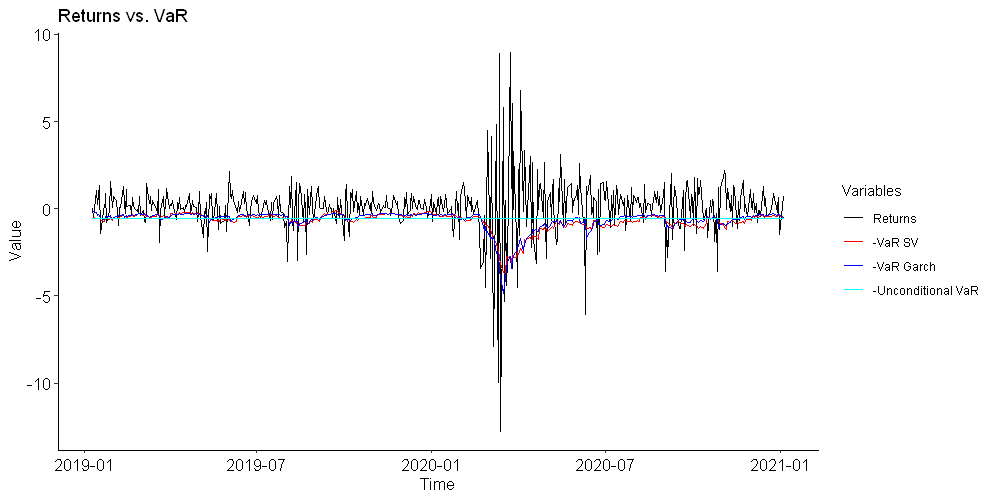

In [882]:
confidence_chart_var

In [883]:
pdf(file=paste0(ILLUS_PATH, "VaR_RD_020.pdf"),width=10, height=5)
confidence_chart_var
dev.off()

png 
  2

### Expected Shortfall

In [884]:
ES_g <- c()
id_g <- c()
ES_sv <- c()
id_sv <- c()

ES_u <- rep(quantile(epsilon, probs = seq(0, 1, 0.01))[alpha1*100+1], 500)

for (t in 1:T){
    if (eta_hat_g[t] < xi_hat_g){
        id_g[t] <- 1
    } else {
        id_g[t] <- 0
    }
}   
eta_hat_g_mod <- id_g * eta_hat_g
eta_hat_g_mod <- eta_hat_g_mod[eta_hat_g_mod!=0]

ES_g <- mean(eta_hat_g_mod) * sqrt(exp(alpha_t))

for (t in 1:T){
    if (eta_hat[t] < xi_hat){
        id_sv[t] <- 1
    } else {
        id_sv[t] <- 0
    }
}   

eta_hat_sv_mod <- id_sv * eta_hat
eta_hat_sv_mod <- eta_hat_sv_mod[eta_hat_sv_mod!=0]

ES_sv <- mean(eta_hat_sv_mod) * sqrt(sigma2_hat)

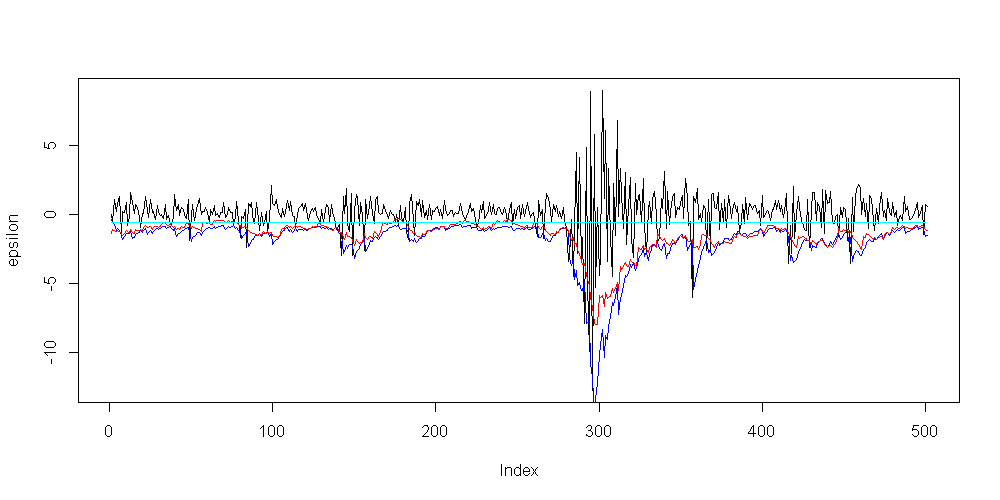

In [885]:
plot(epsilon, type='l', col='black')
lines(ES_sv, type='l', col='blue')
lines(ES_g, type='l', col='red')
lines(ES_u, type='l', col='cyan')

In [886]:
# Load Data
t<-1:T
col_names<-c('t', 'Log-Returns', 'ES Stochastic Volatility', 'ES GARCH', 'ES Unconditional')
es_tab <- as.data.frame(epsilon[1:T])
es_tab <- cbind(es_tab, ES_sv[1:T])
es_tab <- cbind(es_tab, ES_g[1:T])
es_tab <- cbind(es_tab, ES_u[1:T])
es_tab <- cbind(t, es_tab)
colnames(es_tab) <- col_names
es_tab <- melt(es_tab, id="t")
es_tab <- cbind(rep(DATE[1:T]), es_tab)
colnames(es_tab) <- c('Date', 't', 'variable', 'value')

In [887]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100)
es_chart <-ggplot(data=es_tab, aes(x=Date, y=value, colour=variable))+
    geom_line(lwd=0.5)+
    theme_classic()+
    scale_color_manual(name = "Variables", values= c('black', 'red', 'blue', 'cyan'),
                       labels = c('Returns', 'Expected Shortfall SV',
                                  'Expected  Shortfall Garch',
                                  'Unconditional Expected Shortfall'))+
    labs(title = "Returns vs. Expected Shortfall"
         , x = "Time", y="Value")+
    theme(
        axis.title = element_text(size =12),
        axis.text = element_text(size = 12, color = 'black')
    )

Warning message:
"Removed 1 row(s) containing missing values (geom_path)."


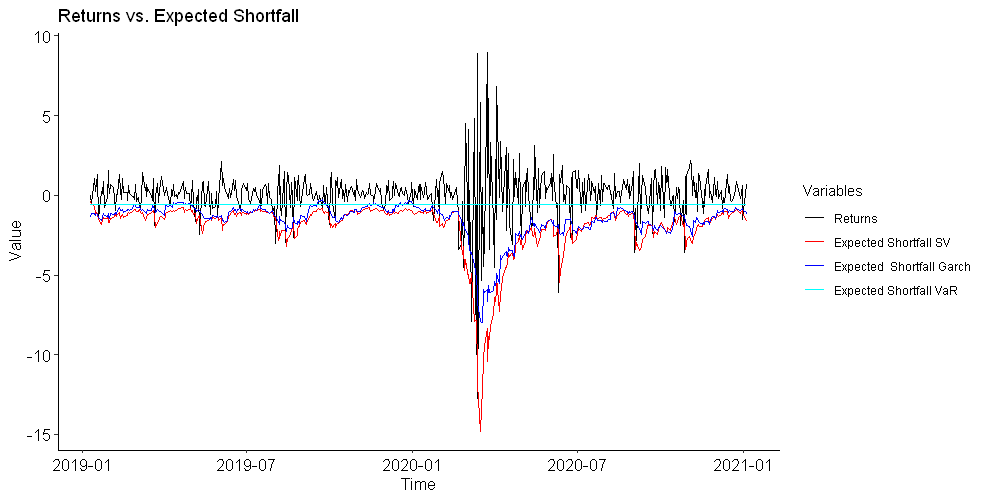

In [888]:
es_chart

In [889]:
pdf(file=paste0(ILLUS_PATH, "ES_RD_020.pdf"),width=10, height=5)
es_chart
dev.off()

Warning message:
"Removed 1 row(s) containing missing values (geom_path)."


png 
  2

### Monte Carlo - on Real Data

In [643]:
T <- 3000
n <- 250
N <- T+n
M <- length(returns[1,]) - 1
epsilon_conso <- returns[,2:(M+1)]

In [644]:
# Initialistation
sigma2_hat_g <- matrix(0, nrow=M, ncol=N)
eta_hat_g <- matrix(0, nrow=M, ncol=N)
VaR_mat_g <- matrix(0, nrow=M, ncol=N)
xi_hat_g <- c()
    
sigma2_hat_sv <- matrix(0, nrow=M, ncol=N)
eta_hat_sv <- matrix(0, nrow=M, ncol=N)
VaR_mat_sv <- matrix(0, nrow=M, ncol=N)
xi_hat_sv <- c()

VaR_mat_u <- matrix(0, nrow=M, ncol=N)

for (j in 1:M){
    epsilon <- epsilon_conso[,j]
    epsilon <- (epsilon+0.00001) * 100
    
    ## 1) Stochastic Volatility Model
    estimation <- estim_sv(theta0, epsilon)
    theta_hat <- estimation
    theta_hat
    
    alpha_t <- c()
    P_t <- c()
    F_t <- c()
    K_t <- c()
    omega <- theta_hat[1]
    beta <- theta_hat[2]
    sigma <- theta_hat[3]
    mu_Z <- -1.270
    sigma_Z <- sqrt(pi**2/2)
    
    a0 <- 0
    beta0 <- 0.8
    P0 <- sigma**2
    F0 <- P0 + sigma_Z**2
    
    y_t <- log(epsilon**2)
    
    alpha_t[1] <- beta0 * a0 + omega
    P_t[1] <- beta**2 * P0 + sigma**2
    K_t[1] <- beta * P0 * 1/F0
    
    for (i in 2:N){
        F_t[i-1] <- P_t[i-1] + sigma_Z**2
        K_t[i] <- beta * P_t[i-1] * 1/F_t[i-1]
        alpha_t[i] <- beta * alpha_t[i-1] + K_t[i] *
                (y_t[i-1] - alpha_t[i-1] - mu_Z) + omega
        P_t[i] <- beta**2 * P_t[i-1] - K_t[i]**2 * F_t[i-1] + sigma**2
    }
    
    sigma2_hat_sv[j,] <- exp(alpha_t)
    eta_hat_sv[j,] <- epsilon / sqrt(exp(alpha_t))
    xi_hat_sv[j] <- quantile(eta_hat_sv[j,1:T], probs = seq(0, 1, 0.01))[alpha1*100+1]
    VaR_mat_sv[j,] <- xi_hat_sv[j] * sqrt(sigma2_hat_sv[j,])
    
    ## 2) GARCH
    estimation_g <- estimgarch11(omega_0, alpha_0, beta_0, epsilon)
    theta_hat_g <- estimation_g$coef

    omega_hat_g <- theta_hat_g[1]
    alpha_hat_g <- theta_hat_g[2]
    beta_hat_g <- theta_hat_g[3]

    sigma2_hat_g[j,1]<-omega_hat_g
    eta_hat_g[j,1] <- epsilon[1] / sqrt(sigma2_hat_g[j,1])
    for (i in 2:N){
        sigma2_hat_g[j,i]<-omega_hat_g + alpha_hat_g * epsilon[i-1]**2 +
            beta_hat_g * sigma2_hat_g[j,i-1]
        eta_hat_g[j,i] <- epsilon[i] / sqrt(sigma2_hat_g[j,i])
    }
    xi_hat_g[j] <- quantile(eta_hat_g[j,1:T], probs = seq(0, 1, 0.01))[alpha1*100+1]
    VaR_mat_g[j,] <- xi_hat_g[j] * sqrt(sigma2_hat_g[j,])
    
    ## 3) unconditional Model
    VaR_mat_u[j,] <- quantile(epsilon[1:T], probs = seq(0, 1, 0.01))[alpha1*100+1]
}

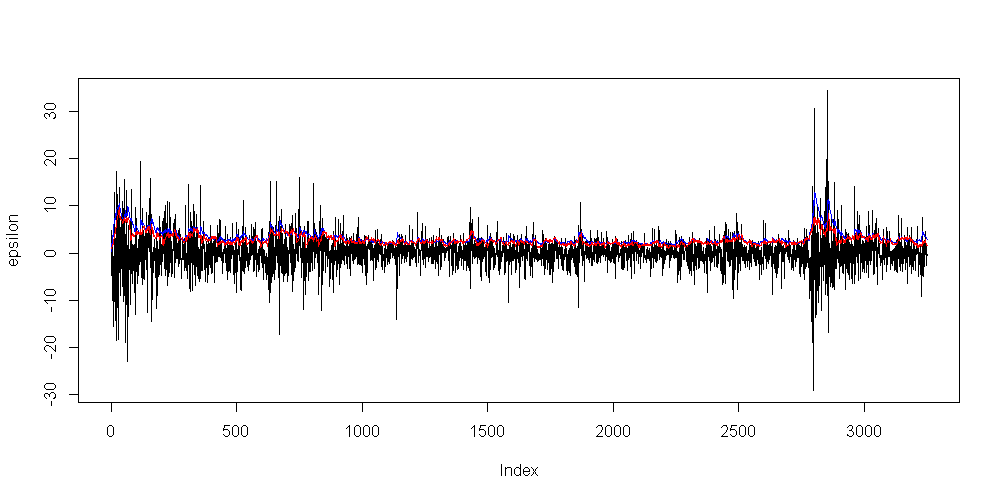

In [645]:
z <- 4
epsilon <- epsilon_conso[,z]
epsilon <- (epsilon+0.00001) * 100
plot(epsilon, type='l', col='black')
lines(sqrt(sigma2_hat_g[z,]), type='l', col='blue')
lines(sqrt(sigma2_hat_sv[z,]), type='l', col='red')

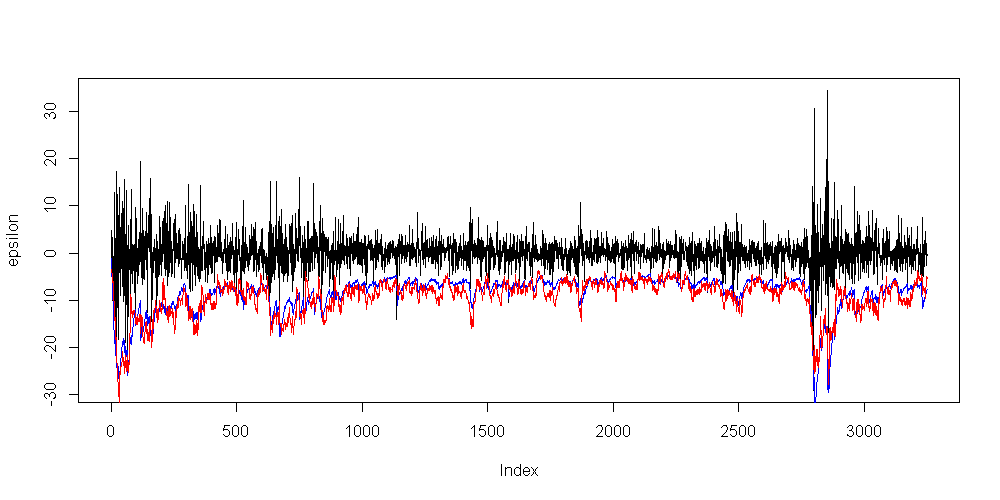

In [646]:
z <- 4
plot(epsilon, type='l', col='black')
lines(VaR_mat_g[z,], type='l', col='blue')
lines(VaR_mat_sv[z,], type='l', col='red')

## Functions

In [647]:
Hit_conso_g <- matrix(0, nrow=M, ncol=n)
Hit_conso_sv <- matrix(0, nrow=M, ncol=n)
Hit_conso_u <- matrix(0, nrow=M, ncol=n)

for (j in 1:M){
    epsilon <- epsilon_conso[,j]
    epsilon <- (epsilon+0.00001) * 100
    VaR_g <- VaR_mat_g[j,]
    VaR_sv <- VaR_mat_sv[j,]
    VaR_u <- VaR_mat_u[j,]
    for (t in (T+1):N){
        if (epsilon[t] < VaR_g[t]){
            Hit_conso_g[j,t-T] <- 1
        }
        if (epsilon[t] < VaR_sv[t]){
            Hit_conso_sv[j,t-T] <- 1
        }
        if (epsilon[t] < VaR_u[t]){
            Hit_conso_u[j,t-T] <- 1
        }
    }
}

### Backtests

In [648]:
chi_level <- c(3.841)

In [649]:
# STOCHASTIC VOLATILITY MODEL
########################################
###### UNCONDITIONAL COVERAGE TEST #####
########################################

UC_test_SV <- LR_uc_test(Hit_conso_sv, alpha1, chi_level)

UC_test_SV$Test_uc # To be compared with 5%

[1] 0.2075218

In [650]:
# GARCH MODEL
########################################
###### UNCONDITIONAL COVERAGE TEST #####
########################################

UC_test_G <- LR_uc_test(Hit_conso_g, alpha1, chi_level)

UC_test_G$Test_uc # To be compared with 5%

[1] 0.1074547

In [651]:
# unconditional MODEL
########################################
###### UNCONDITIONAL COVERAGE TEST #####
########################################

UC_test_U <- LR_uc_test(Hit_conso_u, alpha1, chi_level)

UC_test_U$Test_uc # To be compared with 5%

[1] 0.4096709

In [652]:
# STOCHASTIC VOLATILITY MODEL
########################################
########## INDEPENDENCE TEST ###########
########################################

Ind_test_SV <- LR_ind_test(Hit_conso_sv, alpha1, chi_level)

Ind_test_SV$Test_ind # To be compared with 5%

[1] 0.01746138

In [653]:
# GARCH MODEL
########################################
########## INDEPENDENCE TEST ###########
########################################

Ind_test_G <- LR_ind_test(Hit_conso_g, alpha1, chi_level)

Ind_test_G$Test_ind # To be compared with 5%

[1] 0.01343183

In [654]:
# UNCONDITIONAL MODEL
########################################
########## INDEPENDENCE TEST ###########
########################################

Ind_test_U <- LR_ind_test(Hit_conso_u, alpha1, chi_level)

Ind_test_U$Test_ind # To be compared with 5%

[1] 0.01678979

In [891]:
for (k in 1:5){
    print(k)
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5


In [661]:
chi_level2 <- 5.991

In [662]:
CC_test_G <- LR_cc_test(UC_test_G$LR_uc, Ind_test_G$LR_ind, alpha1, chi_level2)$Test_cc
CC_test_SV <- LR_cc_test(UC_test_SV$LR_uc, Ind_test_SV$LR_ind, alpha1, chi_level2)$Test_cc
CC_test_U <- LR_cc_test(UC_test_U$LR_uc, Ind_test_U$LR_ind, alpha1, chi_level2)$Test_cc

In [663]:
alpha_crit_g <- alpha_crit((epsilon_conso[(T+1):N,]+0.00001) * 100, VaR_mat_g[,(T+1):N], alpha1)
alpha_crit_sv <- alpha_crit((epsilon_conso[(T+1):N,]+0.00001) * 100, VaR_mat_sv[,(T+1):N], alpha1)
alpha_crit_u <- alpha_crit((epsilon_conso[(T+1):N,]+0.00001) * 100, VaR_mat_u[,(T+1):N], alpha1)

In [664]:
results_SV <- c(UC_test_SV$Test_uc, Ind_test_SV$Test_ind, CC_test_SV, mean(alpha_crit_sv$crit))
results_GARCH <- c(UC_test_G$Test_uc, Ind_test_G$Test_ind, CC_test_G, mean(alpha_crit_g$crit))
results_U <- c(UC_test_U$Test_uc, Ind_test_U$Test_ind, CC_test_U, mean(alpha_crit_u$crit))

#### Results

In [665]:
Test_table <- matrix(0, nrow=3, ncol=4)
row_name <- c('SV Model', 'GARCH Model', 'Unconditional Model')
col_name <- c('UC', 'Ind.', 'CC', 'alpha-criterion')
Test_table[1,] <- results_SV
Test_table[2,] <- results_GARCH
Test_table[3,] <- results_U
Test_table <- as.data.frame(Test_table)
rownames(Test_table) <- row_name
colnames(Test_table) <- col_name

In [666]:
Test_table <- round_df(Test_table, 3)
Test_table

,UC,Ind.,CC,alpha-criterion
,<dbl>,<dbl>,<dbl>,<dbl>
SV Model,0.208,0.017,0.021,0.171
GARCH Model,0.107,0.013,0.013,0.199
Unconditional Model,0.410,0.017,0.020,0.155


In [660]:
stargazer(Test_table,  summary=FALSE, covariate.labels=c("A","b","c"),
          title = "Backtesting Results - alpha=0.01",
out = paste0(ILLUS_PATH, "BTEST_Results_SV_001.tex"))


% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: Fri, Sep 09, 2022 - 6:45:12 PM
\begin{table}[!htbp] \centering 
  \caption{Backtesting Results - alpha=0.01} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}} ccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
A & b & c & CC & alpha-criterion \\ 
\hline \\[-1.8ex] 
SV Model & $0.208$ & $0.017$ & $0.238$ & $0.171$ \\ 
GARCH Model & $0.107$ & $0.013$ & $0.148$ & $0.199$ \\ 
Unconditional Model & $0.410$ & $0.017$ & $0.441$ & $0.155$ \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 
